### 1. Import Libraries 

In [154]:
import torch 
import torch.nn as nn 
from torch.optim import lr_scheduler
import numpy as np 
import torchvision
from torchvision import transforms,datasets, models  
import time 
import os 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split


### 2. Set the transforms and isntantiate the model 

In [155]:
visionpro_weights = torchvision.models.AlexNet_Weights.DEFAULT
visionpro = torchvision.models.alexnet(weights=visionpro_weights)
print(visionpro.classifier)
train_transforms = torchvision.transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((227,227)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],std=[0.229,0.224,0.225]),
])
test_transforms = torchvision.transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],std=[0.229,0.224,0.225]),
])

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


### 3. Make train set and test set 

In [156]:
train_dataset = ImageFolder(root="/home/rudgh1999/visionpro/dataset/training_set",transform=train_transforms)
test_dataset = ImageFolder(root="/home/rudgh1999/visionpro/dataset/test_set",
                           transform=test_transforms)

### 4. set to Loader 

In [157]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=4,
                             shuffle=False,
                             num_workers=2)


### 5. Set Classes 

In [158]:
classes = {x: i for i,x in enumerate(train_dataset.classes)}
classes

{'cats': 0, 'dogs': 1}

### 6. Visualize the tensor to image (batch 4 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


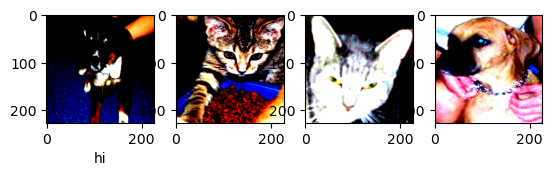

In [159]:
import matplotlib.pyplot as plt 
def image_showing(images):
    fig,ax = plt.subplots(1,4)
    ax[0].imshow(images[0].permute(1,2,0))
    ax[1].imshow(images[1].permute(1,2,0))
    ax[2].imshow(images[2].permute(1,2,0))
    ax[3].imshow(images[3].permute(1,2,0))
    ax[0].set_xlabel('hi')
    
    plt.show()
images = iter(train_dataloader)
images,labels = next(images)
image_showing(images)


### 7. load the model (alexnet)

In [160]:
from torchvision import models 

alexnet_weights = models.AlexNet_Weights.DEFAULT 
alexnet = models.alexnet(weights=alexnet_weights)

### 8. Freezing features 

In [161]:
for i, (name,param) in enumerate(alexnet.named_parameters()):
    print(i,name)

for i, (name,param) in enumerate(alexnet.named_parameters()):
    param.requires_grad = False 
    if i == 9:
        print("end")
        break

0 features.0.weight
1 features.0.bias
2 features.3.weight
3 features.3.bias
4 features.6.weight
5 features.6.bias
6 features.8.weight
7 features.8.bias
8 features.10.weight
9 features.10.bias
10 classifier.1.weight
11 classifier.1.bias
12 classifier.4.weight
13 classifier.4.bias
14 classifier.6.weight
15 classifier.6.bias
end


### 9. Modify the classifier head

In [162]:
from torchinfo import summary 

summary(model = alexnet,
        input_size=(1,3,227,227),
        col_names = ["input_size","output_size","num_params","trainable"] ,
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [1, 3, 227, 227]     [1, 1000]            --                   Partial
├─Sequential (features)                  [1, 3, 227, 227]     [1, 256, 6, 6]       --                   False
│    └─Conv2d (0)                        [1, 3, 227, 227]     [1, 64, 56, 56]      (23,296)             False
│    └─ReLU (1)                          [1, 64, 56, 56]      [1, 64, 56, 56]      --                   --
│    └─MaxPool2d (2)                     [1, 64, 56, 56]      [1, 64, 27, 27]      --                   --
│    └─Conv2d (3)                        [1, 64, 27, 27]      [1, 192, 27, 27]     (307,392)            False
│    └─ReLU (4)                          [1, 192, 27, 27]     [1, 192, 27, 27]     --                   --
│    └─MaxPool2d (5)                     [1, 192, 27, 27]     [1, 192, 13, 13]     --                   --
│    └─Conv2d (6

In [163]:
alexnet.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=9216,out_features=4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,4096),
    nn.ReLU(),
    nn.Linear(4096,len(classes))
)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### 10. Set the optimizer and loss_fn 

In [164]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=alexnet.parameters(),lr=0.001,momentum=0.9)

### 11. Now let's train the model 

In [165]:
torch.manual_seed(42)
NUM_EPOCHS = 5 

for epoch in range(NUM_EPOCHS):
    losses = 0
    total_loss = []
    for idx, (x,y) in enumerate(train_dataloader):
        alexnet.train()
        yhat = alexnet(x)
        loss = loss_fn(yhat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses += loss 
    avg_loss = losses / 1000 
    print(avg_loss)
            

tensor(0.4638, grad_fn=<DivBackward0>)
tensor(0.2409, grad_fn=<DivBackward0>)
tensor(0.2176, grad_fn=<DivBackward0>)
tensor(0.2028, grad_fn=<DivBackward0>)
tensor(0.1782, grad_fn=<DivBackward0>)


### 11. Evaluate the model 

In [166]:
alexnet.eval()
test_loss, test_acc = 0 , 0 
with torch.inference_mode():
    for batch, (x,y) in enumerate(test_dataloader):
        testhat = alexnet(x)
        loss = loss_fn(testhat,y)
        test_loss += loss.item()
        testhat_labels = testhat.argmax(dim=1)
        test_acc += ((testhat_labels==y).sum().item()/len(testhat_labels))
test_loss = test_loss / len(test_dataloader)
test_acc = test_acc / len(test_dataloader)
print(f"[INFO] test_loss : {test_loss}")
print(f"[INFO] test_acc : {test_acc}")

[INFO] test_loss : 0.10340017472937581
[INFO] test_acc : 0.9625


### 12. Save the model 

In [167]:
from pathlib import Path 
target_dir_path = Path("models")
target_dir_path.mkdir(parents=True,
                      exist_ok=True)
model_name = "visionpro_alexnet.pth"
model_save_path = target_dir_path / model_name 
torch.save(obj=alexnet.state_dict(),
           f=model_save_path)

In [226]:
img_path = "/home/rudgh1999/visionpro/wolf.jpeg"
img = Image.open(img_path)
img.mode
tensor_testimg = test_transforms(img)

alexnet.eval()
with torch.inference_mode():
    output = alexnet(tensor_testimg.unsqueeze(dim=0))
    output_soft = torch.softmax(output,dim=1)
    output_label = torch.argmax(output_soft,dim=1)
    print(output_label[0])
    
    print(output_soft)


    

tensor(1)
tensor([[1.2771e-04, 9.9987e-01]])


### 13. Load the model (with save weights)

In [216]:
loaded_model = torchvision.models.alexnet(weights=False)
loaded_model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=9216,out_features=4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,4096),
    nn.ReLU(),
    nn.Linear(4096,len(classes))
)
loaded_model.load_state_dict(torch.load("/home/rudgh1999/visionpro/models/visionpro_alexnet.pth"))

/home/rudgh1999/anaconda3/envs/VisionPro/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [225]:
img_path = "/home/rudgh1999/visionpro/wolf.jpeg"
img = Image.open(img_path)
img.mode
tensor_testimg = test_transforms(img)

alexnet.eval()
with torch.inference_mode():
    output = loaded_model(tensor_testimg.unsqueeze(dim=0))
    output_soft = torch.softmax(output,dim=1)
    output_label = torch.argmax(output_soft,dim=1)
    print(output_label[0])
    
    print(output_soft)

tensor(1)
tensor([[1.2771e-04, 9.9987e-01]])
